# Desafio 4 Gurmendi Alan

## Consigna

Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de
secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en
las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.
- Extras que se pueden probar: Embeddings
pre-entrenados para los dos idiomas; cambiar la
estrategia de generación (por ejemplo muestreo
aleatorio)


---

Para resolver este desafío se toma como base el código brindado por la cátedra. A algunas funciones se le realizaron algunos cambios con el fin de optimizar el uso de la memoria. También se modularizaron algunas secciones con el fin de poder reutilizarlas en los diferentes experimentos

In [5]:
from google.colab import files
uploaded = files.upload()

Saving torch_helpers.py to torch_helpers.py


In [6]:
from torch_helpers import Tokenizer, pad_sequences


In [7]:
!pip install torchinfo
import logging
import os
import pickle
import platform
import re
from io import StringIO
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

from torch_helpers import Tokenizer, pad_sequences


In [8]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [10]:
def sequence_acc(y_pred, y_test):
    # y_pred: (batch, seq_len, vocab)
    # y_test: (batch, seq_len) con índices reales

    y_pred_tag = y_pred.argmax(dim=-1)   # predicción por token
    batch_size = y_pred_tag.shape[0]

    accs = []
    for b in range(batch_size):
        correct = (y_pred_tag[b] == y_test[b]).sum().float()
        accs.append(correct / y_test[b].shape[0])

    return sum(accs) / len(accs)


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:

            train_encoder_input = train_encoder_input.to(device)
            train_decoder_input = train_decoder_input.to(device)
            train_target = train_target.to(device)

            optimizer.zero_grad()


            output = model(train_encoder_input, train_decoder_input)

            loss = 0
            seq_len = train_decoder_input.shape[1]

            for t in range(seq_len):
                loss += criterion(output[:, t, :], train_target[:, t])

            epoch_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss /= len(train_loader)
        epoch_train_accuracy /= len(train_loader)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)

        valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))

        valid_encoder_input = valid_encoder_input.to(device)
        valid_decoder_input = valid_decoder_input.to(device)
        valid_target = valid_target.to(device)

        output = model(valid_encoder_input, valid_decoder_input)

        epoch_valid_loss = 0
        seq_len = valid_decoder_input.shape[1]

        for t in range(seq_len):
            epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t])

        epoch_valid_loss = epoch_valid_loss.item()
        valid_loss.append(epoch_valid_loss)

        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - "
              f"Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - "
              f"Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }

    return history

In [11]:
# Descargar dataset spa-eng si no existe
dataset_folder = "spa-eng"
zip_file = "spa-eng.zip"

if not os.path.exists(dataset_folder):
    print("Descargando dataset spa-eng...")
    url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    gdown.download(url, zip_file, quiet=False)

    import zipfile
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(".")
else:
    print("El dataset ya se encuentra descargado")

Descargando dataset spa-eng...


Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /content/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:00<00:00, 2.95MB/s]


In [12]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [13]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))

        self.decoder_outputs = torch.from_numpy(decoder_output.astype(np.int64))

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self, index):
        return (
            self.encoder_inputs[index],
            self.decoder_inputs[index],
            self.decoder_outputs[index],
        )

    def __len__(self):
        return self.len

In [14]:
def preprocess_sequences(input_sentences,
                         output_sentences,
                         output_sentences_inputs,
                         MAX_VOCAB_SIZE,
                         max_input_len,
                         max_out_len):
    """
    Tokeniza las oraciones de entrada y salida, genera las secuencias numéricas,
    aplica padding y devuelve todo lo necesario para construir el dataset.
    """

    input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    input_tokenizer.fit_on_texts(input_sentences)

    input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

    word2idx_inputs = {
        w: i for w, i in input_tokenizer.word_index.items()
        if i < MAX_VOCAB_SIZE
    }

    output_tokenizer = Tokenizer(
        num_words=MAX_VOCAB_SIZE,
        filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'
    )
    output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)

    output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
    output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

    word2idx_outputs = {
        w: i for w, i in output_tokenizer.word_index.items()
        if i < MAX_VOCAB_SIZE
    }

    num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

    idx2word_outputs = {i: w for w, i in word2idx_outputs.items()}

    encoder_input_sequences = pad_sequences(
        input_integer_seq, maxlen=max_input_len
    )
    decoder_input_sequences = pad_sequences(
        output_input_integer_seq, maxlen=max_out_len, padding='post'
    )
    decoder_output_sequences = pad_sequences(
        output_integer_seq, maxlen=max_out_len, padding='post'
    )

    return {
        "input_tokenizer": input_tokenizer,
        "output_tokenizer": output_tokenizer,
        "word2idx_inputs": word2idx_inputs,
        "word2idx_outputs": word2idx_outputs,
        "idx2word_outputs": idx2word_outputs,
        "num_words_output": num_words_output,
        "encoder_input_sequences": encoder_input_sequences,
        "decoder_input_sequences": decoder_input_sequences,
        "decoder_output_sequences": decoder_output_sequences,
    }

In [15]:
def build_dataset_and_loaders(encoder_input_sequences,
                              decoder_input_sequences,
                              decoder_output_sequences,
                              batch_size=32,
                              valid_fraction=0.2):
    """
    Construye el dataset, lo divide en train/validation
    y retorna los DataLoaders listos para entrenar.
    """

    data_set = Data(
        encoder_input_sequences,
        decoder_input_sequences,
        decoder_output_sequences
    )

    total = len(data_set)
    valid_size = int(total * valid_fraction)
    train_size = total - valid_size

    train_set = torch.utils.data.Subset(data_set, range(train_size))
    valid_set = torch.utils.data.Subset(data_set, range(train_size, total))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    encoder_input_size = encoder_input_sequences.shape[1]
    decoder_input_size = decoder_input_sequences.shape[1]

    return {
        "data_set": data_set,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "encoder_input_size": encoder_input_size,
        "decoder_input_size": decoder_input_size,
        "train_size": train_size,
        "valid_size": valid_size,
    }

In [16]:
def load_sentences(
    filepath="./spa-eng/spa.txt",
    max_sentences=6000,
    seed=40
):
    """
    Carga, mezcla y procesa hasta max_sentences líneas del dataset inglés-español.
    """

    # Leer el archivo
    with open(filepath, encoding="utf8") as f:
        lines = f.read().split("\n")[:-1]

    # Mezclar dataset
    np.random.seed([seed])
    np.random.shuffle(lines)

    input_sentences = []
    output_sentences = []
    output_sentences_inputs = []

    count = 0

    for line in lines:
        if count >= max_sentences:
            break

        if '\t' not in line:
            continue

        eng, spa = line.rstrip().split('\t')

        output_sentence = spa + " <eos>"
        output_sentence_input = "<sos> " + spa

        input_sentences.append(eng)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

        count += 1

    print("Cantidad de rows disponibles:", len(lines))
    print("Cantidad de rows utilizadas:", len(input_sentences))

    return input_sentences, output_sentences, output_sentences_inputs


### 3 - Preparar los embeddings

In [17]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque

if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download
From (redirected): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download&confirm=t&uuid=ffbf2ec0-97bc-4de9-a614-f23be9dfa100
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:12<00:00, 43.3MB/s]


In [18]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [19]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [20]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, lstm_size=128):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers
        )  # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)


class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, lstm_size=128):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers
        )  # LSTM layer
        self.fc1 = nn.Linear(
            in_features=self.lstm_size,
            out_features=self.output_dim
        )  # Fully connected layer

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        logits = self.fc1(lstm_output[:, -1, :])  # (batch, vocab_size)
        return logits, (ht, ct)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim

        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(
            batch_size,
            decoder_input_len,
            vocab_size,
            device=encoder_input.device  # 👈 importante: mismo device que la entrada
        )

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)

        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing"
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # si no se usara teacher forcing:
            # input = top1

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

In [21]:
def translate_sentence(input_text):
    # 1) tokenizar y paddear
    integer_seq = input_tokenizer.texts_to_sequences([input_text])[0]
    encoder_sequence = pad_sequences([integer_seq], maxlen=max_input_len)
    encoder_sequence_tensor = torch.from_numpy(encoder_sequence.astype(np.int32)).to(device)

    # 2) estado inicial del decoder
    prev_state = model.encoder(encoder_sequence_tensor)

    # 3) inicio decoder con <sos>
    target_seq = np.zeros((1, 1), dtype=np.int32)
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq).to(device)

    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output, new_prev_state = model.decoder(target_seq_tensor, prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu().item())

        if idx == eos:
            break

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        prev_state = new_prev_state
        target_seq_tensor = top1.to(device)

    return " ".join(output_sentence)

In [22]:
def predict_random_sentence(model, input_sentences, encoder_input_sequences=None):
    # Elegir índice aleatorio
    i = np.random.choice(len(input_sentences))

    # Frase original en texto
    input_text = input_sentences[i]

    # Obtener traducción a partir del texto
    translation = translate_sentence(input_text)

    # Mostrar resultado
    print('-')
    print("Input:", input_text)
    print("Response:", translation)

### Experimento 1 — Aumentar tamaño del dataset y longitudes máximas

Objetivo: evaluar si el modelo mejora al darle más frases y permitir secuencias más largas.

Datos:

* MAX_NUM_SENTENCES = 20000

* max_input_len = 20

* max_out_len = 22

Arquitectura:

* lstm_size = 128

* 1 capa LSTM

Entrenamiento:

* épocas: 15

* batch size: 32

* learning rate: 0.01

In [23]:
MAX_NUM_SENTENCES = 15000
max_input_len = 20
max_out_len = 22

In [24]:
# 1. Cargar oraciones
input_sentences, output_sentences, output_sentences_inputs = load_sentences(
    filepath="./spa-eng/spa.txt",
    max_sentences=MAX_NUM_SENTENCES,
    seed=40
)

# 2. Preprocesamiento con padding y tokenización
prep = preprocess_sequences(
    input_sentences,
    output_sentences,
    output_sentences_inputs,
    MAX_VOCAB_SIZE,
    max_input_len,
    max_out_len
)

# 3. Dataset y DataLoaders
data = build_dataset_and_loaders(
    prep["encoder_input_sequences"],
    prep["decoder_input_sequences"],
    prep["decoder_output_sequences"],
    batch_size=32,
    valid_fraction=0.2
)

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 15000


In [25]:
input_tokenizer = prep["input_tokenizer"]
output_tokenizer = prep["output_tokenizer"]
num_words_output = prep["num_words_output"]

word2idx_inputs  = prep["word2idx_inputs"]
word2idx_outputs = prep["word2idx_outputs"]

encoder_input_sequences  = prep["encoder_input_sequences"]
decoder_input_sequences  = prep["decoder_input_sequences"]
decoder_output_sequences = prep["decoder_output_sequences"]

In [26]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [27]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))

In [28]:
embed_dim = model_embeddings.N_FEATURES  # 50
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector

In [29]:
data = build_dataset_and_loaders(
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_output_sequences,
    batch_size=32,
    valid_fraction=0.2
)

data_set = data["data_set"]
train_loader = data["train_loader"]
valid_loader = data["valid_loader"]

In [30]:
lstm_size = 128

encoder = Encoder(vocab_size=nb_words, lstm_size=lstm_size).to(device)
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output, lstm_size=lstm_size).to(device)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [31]:
history_exp1 = train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=15
)

Epoch: 1/15 - Train loss 41.760 - Train accuracy 0.733 - Valid Loss 34.153 - Valid accuracy 0.756
Epoch: 2/15 - Train loss 32.135 - Train accuracy 0.759 - Valid Loss 31.268 - Valid accuracy 0.760
Epoch: 3/15 - Train loss 27.764 - Train accuracy 0.770 - Valid Loss 30.931 - Valid accuracy 0.761
Epoch: 4/15 - Train loss 24.426 - Train accuracy 0.783 - Valid Loss 30.967 - Valid accuracy 0.767
Epoch: 5/15 - Train loss 21.788 - Train accuracy 0.796 - Valid Loss 32.295 - Valid accuracy 0.763
Epoch: 6/15 - Train loss 19.593 - Train accuracy 0.810 - Valid Loss 32.759 - Valid accuracy 0.761
Epoch: 7/15 - Train loss 17.828 - Train accuracy 0.822 - Valid Loss 33.512 - Valid accuracy 0.773
Epoch: 8/15 - Train loss 16.474 - Train accuracy 0.833 - Valid Loss 34.724 - Valid accuracy 0.756
Epoch: 9/15 - Train loss 15.332 - Train accuracy 0.843 - Valid Loss 36.152 - Valid accuracy 0.771
Epoch: 10/15 - Train loss 14.425 - Train accuracy 0.850 - Valid Loss 37.528 - Valid accuracy 0.760
Epoch: 11/15 - Trai

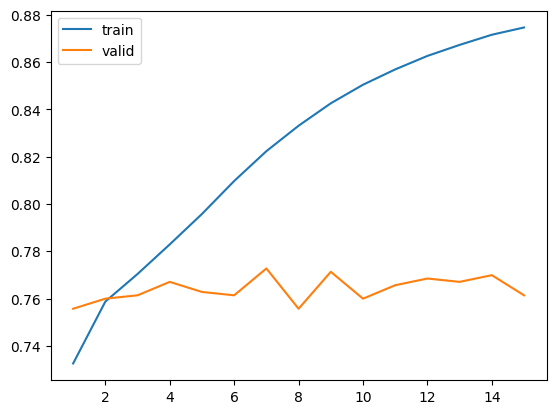

In [32]:
epoch_count = range(1, len(history_exp1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history_exp1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history_exp1['val_accuracy'], label='valid')
plt.show()

Se puede observar que el modelo logra aprender rápidamente y obtiene una buena métrica de accuracy durante las primeras épocas. Sin embargo, después de ese punto comienza a verse sobreajuste

In [33]:
for i in range (1,5):
    predict_random_sentence(model, input_sentences, encoder_input_sequences)

-
Input: Mary wants to buy a dress.
Response: mi esposa es buena cocinera
-
Input: Tom is naked.
Response: tom es creativo
-
Input: I can't hear you.
Response: no puedo oíros
-
Input: Where is my seat?
Response: dónde está el centro comercial


Las traducciones generadas son gramaticalmente correctas y mantienen coherencia en español. No obstante, en la mayoría de los casos no guardan relación con el significado original en inglés. Solo en un caso puntual se observa una buena traduccion

### Experimento 2 — Aumentar la capacidad del modelo (más neuronas LSTM)

Objetivo: analizar si un modelo más grande captura mejor las dependencias a largo plazo.

* MAX_NUM_SENTENCES = 15000

* max_input_len = 20

* max_out_len = 22

* lstm_size = 256 ← duplica el tamaño

* epochs = 15

* learning_rate = 0.01

In [34]:
lstm_size = 256

encoder = Encoder(vocab_size=nb_words, lstm_size=lstm_size).to(device)
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output, lstm_size=lstm_size).to(device)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [35]:
history_exp2 = train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=15
)

Epoch: 1/15 - Train loss 40.225 - Train accuracy 0.738 - Valid Loss 34.156 - Valid accuracy 0.750
Epoch: 2/15 - Train loss 31.092 - Train accuracy 0.760 - Valid Loss 31.697 - Valid accuracy 0.761
Epoch: 3/15 - Train loss 26.366 - Train accuracy 0.772 - Valid Loss 31.311 - Valid accuracy 0.759
Epoch: 4/15 - Train loss 22.746 - Train accuracy 0.790 - Valid Loss 33.026 - Valid accuracy 0.761
Epoch: 5/15 - Train loss 19.780 - Train accuracy 0.809 - Valid Loss 32.927 - Valid accuracy 0.770
Epoch: 6/15 - Train loss 17.487 - Train accuracy 0.827 - Valid Loss 35.003 - Valid accuracy 0.756
Epoch: 7/15 - Train loss 15.784 - Train accuracy 0.841 - Valid Loss 36.667 - Valid accuracy 0.771
Epoch: 8/15 - Train loss 14.567 - Train accuracy 0.850 - Valid Loss 36.894 - Valid accuracy 0.766
Epoch: 9/15 - Train loss 13.689 - Train accuracy 0.858 - Valid Loss 38.045 - Valid accuracy 0.774
Epoch: 10/15 - Train loss 13.029 - Train accuracy 0.863 - Valid Loss 39.302 - Valid accuracy 0.771
Epoch: 11/15 - Trai

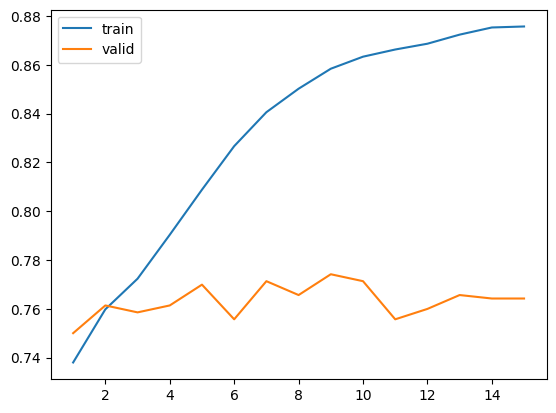

In [36]:
epoch_count = range(1, len(history_exp2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history_exp2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history_exp2['val_accuracy'], label='valid')
plt.show()

Se observa una leve mejora en algunas métricas respecto del experimento anterior, aunque ninguna mejora realmente significativa. Del mismo modo, el modelo vuelve a sobreajustar rápidamente

In [37]:
for i in range (0,5):
    predict_random_sentence(model, input_sentences, encoder_input_sequences)

-
Input: My mother takes a nap every afternoon.
Response: él es más o menos la misma edad
-
Input: Don't pretend what you don't feel.
Response: no puedes levantar el piano de julio de 1888
-
Input: He is in good physical condition.
Response: él es un chico travieso
-
Input: I'm sorry, but it's just not possible.
Response: me pregunto si me hubiera comido el tenis
-
Input: What train you are going to take?
Response: qué vas a hacer el mismo que nos


Al igual que en el primer experimento, las traducciones generadas son frases coherentes y correctas en español, pero no mantienen relación con la frase original en inglés. Esto nos muestra que el aumento en la cantidad de neuronas LSTM no se traduce en una mejora real en la calidad de la traducción, ya que la arquitectura continúa siendo la misma y enfrenta las mismas limitaciones

### Experimento 3 — Dataset grande + más épocas + LSTM 256

Objetivo: combinar las diferentes aumentos con el fin de obtener mejoras en las traducciones

* MAX_NUM_SENTENCES = 30000

* max_input_len = 25

* max_out_len = 28

* lstm_size = 256

* epochs = 25

* learning_rate = 0.008 (un poco más bajo para evitar explosión)

In [38]:
MAX_NUM_SENTENCES = 30000
max_input_len = 25
max_out_len = 28

In [39]:
# 1. Cargar oraciones
input_sentences, output_sentences, output_sentences_inputs = load_sentences(
    filepath="./spa-eng/spa.txt",
    max_sentences=MAX_NUM_SENTENCES,
    seed=40
)

# 2. Preprocesamiento con padding y tokenización
prep = preprocess_sequences(
    input_sentences,
    output_sentences,
    output_sentences_inputs,
    MAX_VOCAB_SIZE,
    max_input_len,
    max_out_len
)

# 3. Dataset y DataLoaders
data = build_dataset_and_loaders(
    prep["encoder_input_sequences"],
    prep["decoder_input_sequences"],
    prep["decoder_output_sequences"],
    batch_size=32,
    valid_fraction=0.2
)

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 30000


In [40]:
input_tokenizer = prep["input_tokenizer"]
output_tokenizer = prep["output_tokenizer"]
num_words_output = prep["num_words_output"]

word2idx_inputs  = prep["word2idx_inputs"]
word2idx_outputs = prep["word2idx_outputs"]

encoder_input_sequences  = prep["encoder_input_sequences"]
decoder_input_sequences  = prep["decoder_input_sequences"]
decoder_output_sequences = prep["decoder_output_sequences"]

In [41]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [42]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))

In [43]:
embed_dim = model_embeddings.N_FEATURES  # 50
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector

In [44]:
data = build_dataset_and_loaders(
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_output_sequences,
    batch_size=32,
    valid_fraction=0.2
)

data_set = data["data_set"]
train_loader = data["train_loader"]
valid_loader = data["valid_loader"]

In [45]:
lstm_size = 256

encoder = Encoder(vocab_size=nb_words, lstm_size=lstm_size).to(device)
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output, lstm_size=lstm_size).to(device)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [46]:
history_exp3 = train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    epochs=25
)

Epoch: 1/25 - Train loss 36.649 - Train accuracy 0.803 - Valid Loss 30.338 - Valid accuracy 0.820
Epoch: 2/25 - Train loss 28.316 - Train accuracy 0.823 - Valid Loss 28.763 - Valid accuracy 0.835
Epoch: 3/25 - Train loss 24.316 - Train accuracy 0.833 - Valid Loss 28.768 - Valid accuracy 0.831
Epoch: 4/25 - Train loss 21.406 - Train accuracy 0.843 - Valid Loss 28.423 - Valid accuracy 0.837
Epoch: 5/25 - Train loss 19.060 - Train accuracy 0.854 - Valid Loss 29.996 - Valid accuracy 0.833
Epoch: 6/25 - Train loss 17.245 - Train accuracy 0.863 - Valid Loss 32.343 - Valid accuracy 0.833
Epoch: 7/25 - Train loss 15.873 - Train accuracy 0.871 - Valid Loss 32.148 - Valid accuracy 0.834
Epoch: 8/25 - Train loss 14.812 - Train accuracy 0.878 - Valid Loss 34.240 - Valid accuracy 0.844
Epoch: 9/25 - Train loss 13.982 - Train accuracy 0.883 - Valid Loss 34.762 - Valid accuracy 0.839
Epoch: 10/25 - Train loss 13.388 - Train accuracy 0.887 - Valid Loss 35.442 - Valid accuracy 0.835
Epoch: 11/25 - Trai

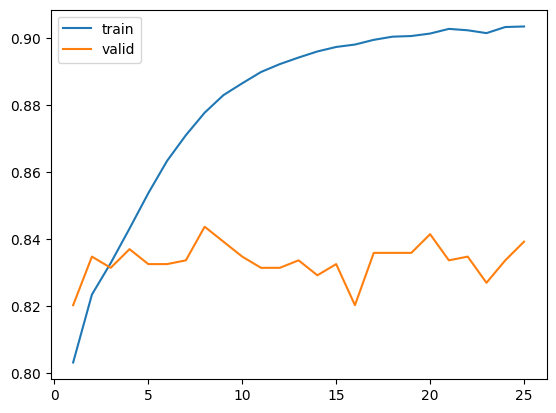

In [47]:
epoch_count = range(1, len(history_exp3['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history_exp3['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history_exp3['val_accuracy'], label='valid')
plt.show()

Al aumentar tanto la cantidad de datos como la cantidad de épocas, se observa una mejora inicial más marcada en las métricas de entrenamiento y validación. Sin embargo, esta mejora se estabiliza rápidamente y vuelve a aparecer sobreajuste

In [48]:
for i in range (0,5):
    predict_random_sentence(model, input_sentences, encoder_input_sequences)

-
Input: Your work has greatly improved.
Response: quieres que te guste
-
Input: Tom is naked.
Response: tom está desnudo
-
Input: I can't hear you.
Response: no puedo ayudar a ti mismo
-
Input: I've got nothing to say to him.
Response: no tengo tiempo para hablar
-
Input: She seemed to be suffering a heart attack.
Response: ella gasta mucho dinero cuando se fuera


A diferencia de los experimentos anteriores, en este caso las traducciones generadas no tienen coherencia en español. A pesar del aumento en la cantidad de datos y de épocas, el modelo no logra estabilizar un comportamiento consistente en la generación de frases.

## Conclusión

Los tres experimentos muestran que la traducción automática es una tarea mucho más compleja de lo que un modelo seq2seq básico puede resolver. Aunque el modelo logra aprender patrones del idioma destino y obtiene buenas métricas internas, esto no se traduce en una traducción real y consistente entre idiomas. Incluso aumentando la cantidad de datos, la capacidad del LSTM o la cantidad de épocas, el modelo no logra capturar el significado original de las frases.
En resumen, para obtener traducciones de calidad se requieren modelos más robustos, junto con una mayor cantidad y variedad de datos de entrenamiento.